In [ ]:
#only needed if you run it in Google Colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create a File Path and list all of the files in that folder.

In [ ]:
import os

#path to the folder where my pkl files are located on Google Drive
folder_path = '/content/drive/My Drive/Colab Notebooks/DL assignment/train'

#list of all files in that folder
file_list = os.listdir(folder_path)

#print the list of pkl files to see if it works - it does
print(file_list)


['21259.pkl', '21248.pkl', '21262.pkl', '21268.pkl', '21244.pkl', '21275.pkl', '21264.pkl', '21252.pkl', '21272.pkl', '21246.pkl', '21265.pkl', '21271.pkl', '21251.pkl', '21267.pkl', '21238.pkl', '21236.pkl', '21245.pkl', '21281.pkl', '21326.pkl', '21319.pkl', '21298.pkl', '21303.pkl', '21314.pkl', '21305.pkl', '21296.pkl', '21286.pkl', '21317.pkl', '21310.pkl', '21325.pkl', '21318.pkl', '21316.pkl', '21294.pkl', '21297.pkl', '21292.pkl', '21324.pkl', '21295.pkl', '21307.pkl', '21304.pkl', '21322.pkl', '21288.pkl', '21320.pkl', '21291.pkl', '21323.pkl', '21285.pkl', '21283.pkl', '21287.pkl', '21293.pkl', '21300.pkl', '21329.pkl', '21313.pkl', '21327.pkl', '21306.pkl', '21280.pkl', '21289.pkl', '21311.pkl', '21321.pkl', '21290.pkl', '21312.pkl', '21308.pkl', '21299.pkl', '21368.pkl', '21374.pkl', '21337.pkl', '21353.pkl', '21370.pkl', '21359.pkl', '21343.pkl', '21364.pkl', '21339.pkl', '21342.pkl', '21348.pkl', '21344.pkl', '21360.pkl', '21341.pkl', '21362.pkl', '21340.pkl', '21351.pkl'

#Create Mel-spectograms out of all audio files.

In [ ]:
import torch
import torchaudio.transforms as T
import os
import pickle

#Set up the Mel-spectrogram transform
n_fft = 2048  #The size of the FFT, which will also determine the number of frequency bins
n_mels = 128  #The number of Mel bands
hop_length = 512  #The hop length between slices
sample_rate = 8000  #The sample rate of the audio files

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

#Function to convert audio to Mel-spectrogram
def audio_to_mel(audio):
    audio_tensor = torch.tensor(audio).float()
    mel_spec = mel_spectrogram(audio_tensor)
    return mel_spec

#Function to load a single pkl file
def load_pkl(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

#Initialize a list to hold all the data
all_data = []

#Processing each .pkl file seperately
for file_name in file_list:
    #Load the audio and valence from the pkl file
    data = load_pkl(os.path.join(folder_path, file_name))

    #Extract the audio data
    audio_data = data['audio_data']

    #Convert the audio to a Mel-spectrogram
    mel_spec = audio_to_mel(audio_data)

    #Store the Mel-spectrogram and valence in the list
    all_data.append((mel_spec, data['valence']))




In [ ]:
#I had some problems with different training the LSTM on the spectrograms - due to a disreptancy in mel-bands among spectrograms
def adjust_mel_specs(data, target_n_mels=128):
    adjusted_data = []
    for mel_spec, valence in data:
        if mel_spec.shape[1] != target_n_mels:
            if mel_spec.shape[1] > target_n_mels:
                #Truncate the excess Mel bands
                adjusted_mel_spec = mel_spec[:, :target_n_mels]
            else:
                #Zero-pad the Mel spectrogram to the right to reach target_n_mels
                padding_size = target_n_mels - mel_spec.shape[1]
                padding = torch.zeros((mel_spec.shape[0], padding_size), dtype=mel_spec.dtype)
                adjusted_mel_spec = torch.cat([mel_spec, padding], dim=1)
            adjusted_data.append((adjusted_mel_spec, valence))
        else:
            adjusted_data.append((mel_spec, valence))
    return adjusted_data

#Apply the adjustment to the entire dataset
all_data = adjust_mel_specs(all_data)


#Verification code
def verify_adjusted_mel_specs(data):
    for idx, (mel_spec, valence) in enumerate(data):
        assert mel_spec.shape[1] == 128, f"Mel spectrogram at index {idx} does not have 128 Mel bands."

verify_adjusted_mel_specs(all_data)
print("All Mel spectrograms have been successfully adjusted to 128 Mel bands.") #seems like the spectrograms are all equal in Mel bands now!


All Mel spectrograms have been successfully adjusted to 128 Mel bands.


#Visualize Spectrograms

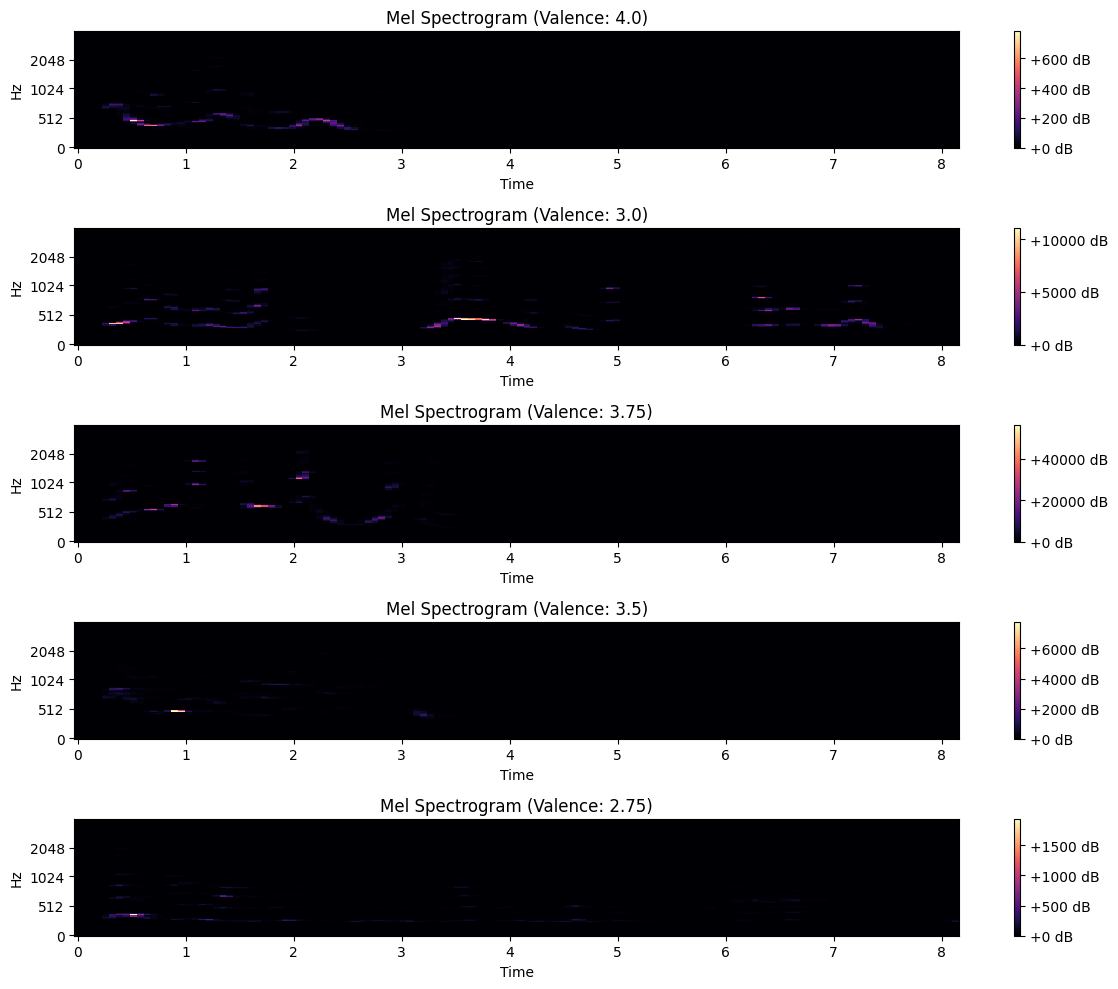

In [ ]:
#in order to find out what the best preprocessing steps would be
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch

#Taking just the first 5 spectrograms
sample_data = all_data[:5]

#Function to display Mel spectrograms
def display_mel_spectrograms(data, sr=8000):
    fig, axes = plt.subplots(nrows=len(data), figsize=(12, 10))
    if len(data) == 1:
        axes = [axes]

    for ax, (mel_spec, valence) in zip(axes, data):
        #Check if mel_spec is a tensor and convert it to numpy if it is
        if isinstance(mel_spec, torch.Tensor):
            mel_spec = mel_spec.numpy()

        #If mel_spec is two-dimensional (features over time), display it
        if mel_spec.ndim == 2:
            img = librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', ax=ax, fmax=sr//2)
            ax.set(title=f'Mel Spectrogram (Valence: {valence})')
            fig.colorbar(img, ax=ax, format="%+2.f dB")

    plt.tight_layout()
    plt.show()

#Display the Mel spectrograms for the sample data
display_mel_spectrograms(sample_data)

#Based on the first 5 entries, it is clear that the spectrograms vary a lot in length



# Model Architecture: LSTM

In [9]:
import torch
import torch.nn as nn

#Based off of the knowledge in week 10's module, we thought it would be wise to try out a (bidrectional) LSTM model for sequence data like in this task.


class ValencePredictor(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, output_size=1, bidirectional=True):
        super(ValencePredictor, self).__init__()
        self.bidirectional = bidirectional  #Store the bidirectional setting as an instance variable
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,  #initially started with 1 layer, but 2 yielded better results.
                            dropout=0.2,  #initially we had implemented no dropout, but after evaluation with dropout the model gave better results.
                            batch_first=True,
                            bidirectional=bidirectional) #it is set to true in our final solution

        #depending on bidrectional or unidirectional LSTM
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * factor, output_size)  # Double the hidden_size if bidirectional

    def forward(self, x, seq_lengths):
        #Pack the padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_input)

        #Handling the LSTM output for bidirectional/unidirectional cases
        if self.bidirectional:
            #Concatenate the hidden states of the last layer for both directions
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            #Use the hidden state of the last layer (last time step)
            hidden = hidden[-1, :, :]

        #Pass the output of LSTM to the fully connected layer
        output = self.fc(hidden)
        return output


#Split Data

In [ ]:
from sklearn.model_selection import train_test_split

#80/20 split
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42)


# Create a DataLoader with a custom collate function.

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn.utils.rnn import pad_sequence

#inheritance from PyTorch class
class MelSpectrogramDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


#to combine multiple data samples into a batch, essential for handling varying lengths of sequences:
def collate_fn(batch):
    sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]  #This line extracts the mel spectrogram sequences from the batch and converts each into a tensor.
    valences = torch.tensor([val for _, val in batch], dtype=torch.float32).unsqueeze(1) #This line extracts a secondary attribute (val) associated with each sequence, converting it into a tensor and adding an extra dimension.

    #Compute the lengths of each sequence before padding
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)

    #Pad sequences to have the same length
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)

    return sequences_padded, valences, lengths # thisd function returns a tuple containing the padded sequences, their corresponding valences, and their original lengths.



train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)



#Quick test to confirm DataLoader functionality
try:
    for mel_specs, valences in train_loader:
        print("Batch shapes:", mel_specs.shape, valences.shape)
        break  # Test only the first batch
    print("DataLoader works fine!")
except Exception as e:
    print("Error in DataLoader:", e)


Error in DataLoader: too many values to unpack (expected 2)


<ipython-input-13-0d573acd4eb6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]


# Create Loss function and optimizer

In [ ]:
import torch.optim as optim

model = ValencePredictor()  #LSTM model
criterion = torch.nn.MSELoss()  #Mean-Squared Error loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  #L2 regularization with Adam Optimzer, and initial learning rate of 0.001

#Implementing a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  #Reduce the learning rate every 5 epochs



# Set up a Cuda Device


In [ ]:
import torch

#Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Move the model to the chosen device
model.to(device)





Using device: cpu


ValencePredictor(
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

# Train the model

In [ ]:
#Create a directory to save for every epoch
model_save_dir = '/content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

#Specify the path to save the model
model_save_path = os.path.join(model_save_dir, 'valence_predictor.pth')



#Define the number of epochs
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for mel_specs, valences, lengths in train_loader:
        mel_specs, valences, lengths = mel_specs.to(device), valences.to(device), lengths.to(device)

        optimizer.zero_grad()  #Clear gradients for this training step
        outputs = model(mel_specs, lengths)  #Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, valences)  #Calculate the loss
        loss.backward()  #Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  #Perform a single optimization step

        total_train_loss += loss.item() * mel_specs.size(0)  #Aggregate the loss

    #Calculate average loss over the training data
    avg_train_loss = total_train_loss / len(train_loader.dataset)

    #Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for mel_specs, valences, lengths in val_loader:
            mel_specs, valences, lengths = mel_specs.to(device), valences.to(device), lengths.to(device)
            outputs = model(mel_specs, lengths)
            val_loss = criterion(outputs, valences)
            total_val_loss += val_loss.item() * mel_specs.size(0)  #Aggregate the validation loss

    #Calculate average loss over the validation data
    avg_val_loss = total_val_loss / len(val_loader.dataset)

    print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")




<ipython-input-13-0d573acd4eb6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]


Epoch 1: Training Loss: 0.9580, Validation Loss: 0.6725
Model saved to /content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model/valence_predictor.pth
Epoch 2: Training Loss: 0.6774, Validation Loss: 0.6575
Model saved to /content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model/valence_predictor.pth
Epoch 3: Training Loss: 0.6742, Validation Loss: 0.6539
Model saved to /content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model/valence_predictor.pth
Epoch 4: Training Loss: 0.6675, Validation Loss: 0.6542
Model saved to /content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model/valence_predictor.pth
Epoch 5: Training Loss: 0.6550, Validation Loss: 0.6503
Model saved to /content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model/valence_predictor.pth
Epoch 6: Training Loss: 0.6458, Validation Loss: 0.6452
Model saved to /content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model/valence_predictor.pth
Epoch 7: Training Loss: 0.6355, Validation Loss: 0.6

# Evaluate on the Validation set


In [ ]:
import torch

#Ensure the model is in evaluation mode
model.eval()

#Prepare to collect predictions and actuals
predictions = []
actuals = []

#Evaluate on the validation set
with torch.no_grad():
    for mel_specs, valences, lengths in val_loader:
        mel_specs, valences, lengths = mel_specs.to(device), valences.to(device), lengths.to(device)

        #Forward pass to get outputs
        outputs = model(mel_specs, lengths)

        #Store predictions and actuals
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(valences.view(-1).tolist())

#Calculate the evaluation metric
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actuals, predictions)

print(f"Mean Squared Error on the Validation Set: {mse:.4f}")


<ipython-input-13-0d573acd4eb6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [torch.tensor(seq, dtype=torch.float32) for seq, _ in batch]


Mean Squared Error on the Validation Set: 0.6738


# Evaluate on the Test set



First perform same preprocessing as with the test and validation set.

In [2]:
import torch
import torchaudio.transforms as T
import os
import pickle

# Setup paths and files
folder_path = '/content/drive/My Drive/Colab Notebooks/DL assignment/test'
file_list2 = os.listdir(folder_path)


In [4]:
#print the list of pkl files to see if it works
print(file_list2)

['15542.pkl', '15856.pkl', '15661.pkl', '15590.pkl', '15839.pkl', '15901.pkl', '15616.pkl', '15898.pkl', '15913.pkl', '15793.pkl', '15862.pkl', '15903.pkl', '15562.pkl', '15840.pkl', '15937.pkl', '15582.pkl', '15922.pkl', '15771.pkl', '15520.pkl', '15700.pkl', '15543.pkl', '15691.pkl', '15726.pkl', '15680.pkl', '15682.pkl', '15761.pkl', '15760.pkl', '15801.pkl', '15695.pkl', '15620.pkl', '15849.pkl', '15800.pkl', '15604.pkl', '15481.pkl', '15646.pkl', '15886.pkl', '15892.pkl', '15606.pkl', '15523.pkl', '15918.pkl', '15743.pkl', '15767.pkl', '15675.pkl', '15707.pkl', '15855.pkl', '15484.pkl', '15872.pkl', '15653.pkl', '15752.pkl', '15555.pkl', '15540.pkl', '15678.pkl', '15941.pkl', '15907.pkl', '15868.pkl', '15597.pkl', '15477.pkl', '15493.pkl', '15961.pkl', '15560.pkl', '15596.pkl', '15672.pkl', '15809.pkl', '15885.pkl', '16213.pkl', '16294.pkl', '16286.pkl', '16306.pkl', '16009.pkl', '16384.pkl', '16187.pkl', '16368.pkl', '16358.pkl', '16064.pkl', '16086.pkl', '16371.pkl', '16367.pkl'

Create the same type of mel-spectrograms as with the training data.

In [6]:
import torch
import torchaudio.transforms as T
import os
import pickle

#Set up the Mel-spectrogram transform
n_fft = 2048  #The size of the FFT, which will also determine the number of frequency bins
n_mels = 128  #The number of Mel bands
hop_length = 512  #The hop length between slices
sample_rate = 8000  #The sample rate of the audio files

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

#Function to convert audio to Mel-spectrogram
def audio_to_mel(audio):
    audio_tensor = torch.tensor(audio).float()
    mel_spec = mel_spectrogram(audio_tensor)
    return mel_spec

#Function to load a single pkl file
def load_pkl(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

#Initialize a list to hold all the data
all_data = []

#Processing each .pkl file
for file_name in file_list2:
    #Load the audio and valence from the pkl file
    data = load_pkl(os.path.join(folder_path, file_name))

    #Extract the audio data
    audio_data = data['audio_data']

    #Convert the audio to a Mel-spectrogram
    mel_spec = audio_to_mel(audio_data)

    #Store the Mel-spectrogram and valence in the list
    all_data.append((mel_spec))

print(all_data[1])



tensor([[7.2236e-10, 8.6475e-09, 3.9191e-08,  ..., 6.0957e-08, 5.7154e-08,
         1.0375e-07],
        [2.5904e-09, 2.0786e-08, 6.4788e-08,  ..., 1.3518e-07, 8.7052e-08,
         1.8351e-07],
        [1.7005e-08, 2.9568e-08, 3.6482e-08,  ..., 5.1757e-08, 1.0800e-07,
         3.4536e-07],
        ...,
        [3.4870e-07, 1.5536e-04, 6.8887e-03,  ..., 5.8284e-05, 2.7836e-06,
         1.5613e-06],
        [8.9194e-08, 1.2535e-04, 3.6956e-03,  ..., 1.3593e-05, 1.6996e-06,
         6.9229e-07],
        [1.1080e-09, 3.7154e-06, 8.6672e-05,  ..., 2.0070e-07, 1.2904e-08,
         5.2699e-07]])


In [7]:
#I had some problems with different training the LSTM on the spectrograms - due to a disreptancy in mel-bands among spectrograms
def adjust_mel_specs(data, target_n_mels=128):
    adjusted_data = []
    for mel_spec in data:
        if mel_spec.shape[1] != target_n_mels:
            if mel_spec.shape[1] > target_n_mels:
                #Truncate the excess Mel bands
                adjusted_mel_spec = mel_spec[:, :target_n_mels]
            else:
                #Zero-pad the Mel spectrogram to the right to reach target_n_mels
                padding_size = target_n_mels - mel_spec.shape[1]
                padding = torch.zeros((mel_spec.shape[0], padding_size), dtype=mel_spec.dtype)
                adjusted_mel_spec = torch.cat([mel_spec, padding], dim=1)
            adjusted_data.append((adjusted_mel_spec))
        else:
            adjusted_data.append((mel_spec))
    return adjusted_data

#Apply the adjustment to the entire dataset
all_data = adjust_mel_specs(all_data)


#Verification code
def verify_adjusted_mel_specs(data):
    for idx, (mel_spec) in enumerate(data):
        assert mel_spec.shape[1] == 128, f"Mel spectrogram at index {idx} does not have 128 Mel bands."

verify_adjusted_mel_specs(all_data)
print("All Mel spectrograms have been successfully adjusted to 128 Mel bands.") #seems like the spectrograms are all equal in Mel bands now!


All Mel spectrograms have been successfully adjusted to 128 Mel bands.


#Run the experiment and put the results in a CSV file.

In [12]:
import pandas as pd

model = ValencePredictor()

#Load the state dictionary
state_dict = torch.load("/content/drive/My Drive/Colab Notebooks/DL assignment/LSTM_Model/valence_predictor.pth")  #the saved bidrectional LSTM model from training
model.load_state_dict(state_dict)

#Ensure the model is in evaluation mode
model.eval()

#Use CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#Prepare to collect predictions
predictions = []

#Evaluate on the all_data test list
with torch.no_grad():
    for mel_spec in all_data:
        #mel_spec is a tensor of shape (seq_len, input_size)
        seq_length = torch.tensor([mel_spec.size(0)])  #get sequence length
        mel_spec = mel_spec.unsqueeze(0).to(device)  #Add batch dimension and move to device
        seq_length = seq_length.to(device)  #Move sequence length to device

        #Forward pass to get outputs
        output = model(mel_spec, seq_length)

        #Store predictions
        predictions.append(output.item())


#Create a DataFrame to store the results
results_df = pd.DataFrame({
    "ID": file_list2,
    "Label": predictions
})

#Export the results to a CSV file
results_df.to_csv("predictions.csv", index=False)

print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv
